In [323]:
import pandas as pd
import numpy as np

## Preparing the dataset for running the clustering model

We need to run a clystering model in order to cluster similar stores together. The similarity will be based:

Number of Transactions of each store

% Sales generated by each store for each family of products

In [ ]:
# Importing the datasets- Train, which contains the information of transactions for each store and item, and items, which
# contains the information of the items sold in all stores across Ecuador
# The train dataset contains 217 million rows, therefore it will take sometime to import the dataset

df = pd.read_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\Data Files\\train.csv")

In [ ]:
# train.csv
# items.csv

In [37]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ GB


In [39]:
# Checking if there are any missing values
df.isnull().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    21657651
dtype: int64

For this analysis, the column 'onpromotion' is not important, therefore for now we decide to not take any action towards resolving the missing values that fall under this column

In [40]:
# Also importing the items dataset, to join it with our main dataset to get the information about family of each item_nbr
items = pd.read_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\Data Files\\items.csv")
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [41]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


In [42]:
# Checking for missing values
items.isnull().sum()

item_nbr      0
family        0
class         0
perishable    0
dtype: int64

In [43]:
# Checking the number of unique families of products
len(items['family'].unique())

33

<AxesSubplot:>

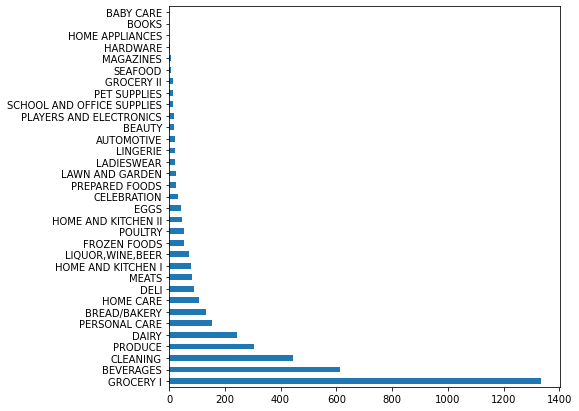

In [44]:
# Checking the number of items present under each family
items['family'].value_counts().plot(kind= 'barh', figsize = (7,7))

From the items dataset we see that there are 4100 unique products and they are categorized under 33 unique families

In [45]:
# Merging df and items
df_with_items = pd.merge(df, items, on= 'item_nbr', how = 'inner')
df_with_items.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
0,0,2013-01-01,25,103665,7.0,NaN,BREAD/BAKERY,2712,1
1,578,2013-01-02,1,103665,2.0,NaN,BREAD/BAKERY,2712,1
2,1596,2013-01-02,2,103665,5.0,NaN,BREAD/BAKERY,2712,1
3,2699,2013-01-02,3,103665,6.0,NaN,BREAD/BAKERY,2712,1
4,3900,2013-01-02,4,103665,2.0,NaN,BREAD/BAKERY,2712,1


In [46]:
# Saving df_with_items for future use
df_with_items.to_pickle('df_with_items')

In [2]:
# Reading the pickle file- df_with_items
df_with_items = pd.read_pickle('df_with_items')

In [1224]:
df_with_items['date']= pd.to_datetime(df_with_items['date'])

In [147]:
df_with_items[df_with_items['unit_sales'] < 0].groupby(['store_nbr','family'])['unit_sales'].sum().sort_values(ascending= True)

store_nbr  family       
18         BEVERAGES       -15920.000
32         GROCERY I       -10195.495
2          GROCERY I        -8064.000
53         PERSONAL CARE    -7208.000
           CLEANING         -5406.000
                              ...    
16         MEATS               -0.168
10         PRODUCE             -0.146
9          MEATS               -0.060
1          SEAFOOD             -0.045
53         POULTRY             -0.013
Name: unit_sales, Length: 1060, dtype: float64

In [155]:
# Calculating the total number of items sold for each store
items_sold = df_with_items[df_with_items['unit_sales'] > 0].groupby('store_nbr')['unit_sales'].sum()
# Resetting the index, which is the store number, as a column of the dataframe
items_sold = items_sold.reset_index()
# Renaming the unit_sales column to total_sales
items_sold = items_sold.rename(columns = {'unit_sales':'total_sales'})

In [156]:
items_sold.head()

,store_nbr,total_sales
0,1,1.414660e+07
1,2,2.156755e+07
2,3,5.048553e+07
3,4,1.891105e+07
4,5,1.559287e+07


In [157]:
# Calculating the total items sold for each store by family
items_sold_by_family = df_with_items[df_with_items['unit_sales'] > 0].groupby(['store_nbr', 'family'])['unit_sales'].sum()
# Resetting the columns in items_sold_by_family
items_sold_by_family = items_sold_by_family.reset_index(level= ['store_nbr', 'family'])
# Changing the name of unit_sales column to total_sales
items_sold_by_family = items_sold_by_family.rename(columns= {'unit_sales': 'total_sales_family'})

In [158]:
items_sold_by_family.head()

,store_nbr,family,total_sales_family
0,1,AUTOMOTIVE,5476.000
1,1,BEAUTY,4057.000
2,1,BEVERAGES,2674096.000
3,1,BOOKS,211.000
4,1,BREAD/BAKERY,570012.208


In [1174]:
# Merging items_sold and items_sold_by_family in order to get all the information into a single dataframe and compute
# the percentage share of each family in each store

share_of_sales_by_fam = pd.merge(items_sold_by_family, 
                                 items_sold, 
                                 on= 'store_nbr', 
                                 how= 'inner')

In [1175]:
share_of_sales_by_fam.head()

,store_nbr,family,total_sales_family,total_sales
0,1,AUTOMOTIVE,5476.000,1.414660e+07
1,1,BEAUTY,4057.000,1.414660e+07
2,1,BEVERAGES,2674096.000,1.414660e+07
3,1,BOOKS,211.000,1.414660e+07
4,1,BREAD/BAKERY,570012.208,1.414660e+07


In [1176]:
share_of_sales_by_fam['family'].unique()

array(['AUTOMOTIVE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY',
       'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS',
       'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE',
       'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
       'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE',
       'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD', 'BABY CARE'], dtype=object)

In [1177]:
share_of_sales_by_fam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 0 to 1728
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_nbr           1729 non-null   int64  
 1   family              1729 non-null   object 
 2   total_sales_family  1729 non-null   float64
 3   total_sales         1729 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 67.5+ KB


It seems that some stores do not have products from all families, or it is all possible that the products from those families were never sold at those stores even if some inventory was maintained

In [1178]:
families_per_store = pd.DataFrame(share_of_sales_by_fam.groupby('store_nbr')['family'].count())

In [1179]:
families_per_store[families_per_store['family'] < 33]

,family
store_nbr,
1,32
9,32
10,32
11,32
12,32
13,31
14,31
15,32
16,31


In [1180]:
stores_per_family = pd.DataFrame(share_of_sales_by_fam.groupby('family')['store_nbr'].count())
stores_per_family[stores_per_family['store_nbr'] < 54]

,store_nbr
family,
BABY CARE,42
BOOKS,26
LADIESWEAR,44
LAWN AND GARDEN,51


The above four families are only sold at some stores. Therefore, while finding out the percentage share of sales of each family for each store, we will not group these families into 'Other' category even if their share of sales is very less.

In [1181]:
# Now calculating the share of sales of each family for each store
share_of_sales_by_fam['sales_share_family'] = (
    share_of_sales_by_fam['total_sales_family'] / share_of_sales_by_fam['total_sales'])*100

In [1182]:
# Sorting the values in the above dataframe
share_of_sales_by_fam = share_of_sales_by_fam.sort_values(['store_nbr', 'sales_share_family'], ascending= [True, False])
share_of_sales_by_fam.head()

,store_nbr,family,total_sales_family,total_sales,sales_share_family
11,1,GROCERY I,3.744607e+06,1.414660e+07,26.470016
2,1,BEVERAGES,2.674096e+06,1.414660e+07,18.902748
29,1,PRODUCE,2.443336e+06,1.414660e+07,17.271545
6,1,CLEANING,1.078605e+06,1.414660e+07,7.624483
7,1,DAIRY,1.054379e+06,1.414660e+07,7.453233


In [1183]:
share_of_sales_by_fam[share_of_sales_by_fam['store_nbr'] == 1]['sales_share_family'].sum()

100.00000000000182

In [1185]:
# Grouping Grocery I and Grovery II as GROCERIES
share_of_sales_by_fam.loc[
    (share_of_sales_by_fam['family'] == 'GROCERY I') | 
    (share_of_sales_by_fam['family'] == 'GROCERY II'), 'family'] = 'GROCERIES'

In [1186]:
# Grouping Home and Kitchen I and Home and Kitchen II as HOME AND KITCHEN
share_of_sales_by_fam.loc[
    (share_of_sales_by_fam['family'] == 'HOME AND KITCHEN I') | 
    (share_of_sales_by_fam['family'] == 'HOME AND KITCHEN II'), 'family'] = 'HOME AND KITCHEN'

In [1187]:
# Calculating the sum of sales_share_family for each family
total_family_share = share_of_sales_by_fam.groupby('family')['sales_share_family'].sum().sort_values(ascending= False)
total_family_share = total_family_share.reset_index()
total_family_share

,family,sales_share_family
0,GROCERIES,1814.155295
1,BEVERAGES,1080.860148
2,PRODUCE,553.191654
3,CLEANING,527.516951
4,DAIRY,304.687319
5,BREAD/BAKERY,210.238946
6,MEATS,146.549459
7,POULTRY,139.618117
8,PERSONAL CARE,130.156835
9,DELI,128.777371


In [1188]:
# Joining share_of_sales_by_fam and total_family_share
share_of_sales_by_fam = pd.merge(share_of_sales_by_fam, 
                                 total_family_share, 
                                 on = 'family', 
                                 how = 'inner')

In [1189]:
share_of_sales_by_fam = share_of_sales_by_fam.rename(
    columns = {'sales_share_family_x': 'sales_share_family', 
               'sales_share_family_y': 'total_family_share_across_stores'})

In [1190]:
# Categorizing those families as 'Other' where the total_family_share_across_stores < 40%
list_of_families = list(
    share_of_sales_by_fam[share_of_sales_by_fam['total_family_share_across_stores'] < 40]['family'].unique())

In [1191]:
list_of_families

['PREPARED FOODS',
 'SEAFOOD',
 'HOME AND KITCHEN',
 'CELEBRATION',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'PLAYERS AND ELECTRONICS',
 'PET SUPPLIES',
 'AUTOMOTIVE',
 'MAGAZINES',
 'BEAUTY',
 'HARDWARE',
 'HOME APPLIANCES',
 'SCHOOL AND OFFICE SUPPLIES',
 'BOOKS',
 'BABY CARE']

In [1192]:
# Removing the following families as they aren't sold at all stores, so if we include these 'OTHER' category would not be
# representative for all the stores
list_of_families.remove('LADIESWEAR')
list_of_families.remove('LAWN AND GARDEN')
list_of_families.remove('BOOKS')
list_of_families.remove('BABY CARE')

In [1193]:
# Adding 'EGGS' under 'OTHER' too, as the clustering model gives better results when we add 'EGGS' family to 'OTHER'
list_of_families.append('EGGS')

In [1194]:
list_of_families

['PREPARED FOODS',
 'SEAFOOD',
 'HOME AND KITCHEN',
 'CELEBRATION',
 'LINGERIE',
 'PLAYERS AND ELECTRONICS',
 'PET SUPPLIES',
 'AUTOMOTIVE',
 'MAGAZINES',
 'BEAUTY',
 'HARDWARE',
 'HOME APPLIANCES',
 'SCHOOL AND OFFICE SUPPLIES',
 'EGGS']

In [1110]:
share_of_sales_by_fam.loc[share_of_sales_by_fam['family'].isin(list_of_families), 'family'] = 'OTHER'

In [1113]:
share_of_sales_by_fam['family'].value_counts()

OTHER               810
GROCERIES           108
CLEANING             54
PERSONAL CARE        54
MEATS                54
DAIRY                54
PRODUCE              54
FROZEN FOODS         54
POULTRY              54
LIQUOR,WINE,BEER     54
BEVERAGES            54
DELI                 54
HOME CARE            54
BREAD/BAKERY         54
LAWN AND GARDEN      51
LADIESWEAR           44
BABY CARE            42
BOOKS                26
Name: family, dtype: int64

In [1173]:
share_of_sales_by_fam.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\share_of_sales_by_family.csv")

In [1114]:
# Creating the final dataframe that will be used for clustering
final_df = pd.pivot_table(share_of_sales_by_fam, 
                          values= 'sales_share_family', 
                          index= 'store_nbr', 
                          columns= ['family'], aggfunc = np.sum)
# Resetting the index in order to add the store_nbr as column instead of having it as index
final_df = final_df.reset_index()

In [1115]:
final_df.head()

family,store_nbr,BABY CARE,BEVERAGES,BOOKS,BREAD/BAKERY,CLEANING,DAIRY,DELI,FROZEN FOODS,GROCERIES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEATS,OTHER,PERSONAL CARE,POULTRY,PRODUCE
0,1,NaN,18.902748,0.001492,4.029323,7.624483,7.453233,1.463511,1.540569,26.730029,1.203477,0.112006,0.107227,1.202565,3.729644,3.706572,1.537917,3.383659,17.271545
1,2,0.000389,19.260932,0.001108,4.285650,7.539144,6.662193,1.907932,1.254980,30.841461,1.386907,0.137011,0.064282,0.675594,3.940995,3.283531,2.059788,3.799749,12.898353
2,3,0.001331,22.487688,0.001070,3.837526,6.882394,6.807689,1.316565,1.498906,25.952200,1.082094,0.103020,0.081837,0.732337,2.706705,3.994024,1.679733,3.773844,17.061038
3,4,0.000127,19.400316,0.001407,3.611438,7.878741,7.028889,1.923636,1.341576,29.991410,1.369247,0.135344,0.083385,0.740429,3.291591,3.216057,2.030527,3.997834,13.958046
4,5,0.001379,16.251393,0.001475,4.122759,10.695893,5.587790,2.663210,1.729505,33.964111,1.534573,0.095037,0.031874,0.708336,3.059760,3.369688,2.887050,2.691282,10.604885


In [1116]:
# Checking if the sum of 'Others' worked 
share_of_sales_by_fam.loc[(share_of_sales_by_fam['family'] == 'OTHER') & (share_of_sales_by_fam['store_nbr'] == 2),'sales_share_family' ].sum()

3.283531486341601

In [1117]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   store_nbr         54 non-null     int64  
 1   BABY CARE         42 non-null     float64
 2   BEVERAGES         54 non-null     float64
 3   BOOKS             26 non-null     float64
 4   BREAD/BAKERY      54 non-null     float64
 5   CLEANING          54 non-null     float64
 6   DAIRY             54 non-null     float64
 7   DELI              54 non-null     float64
 8   FROZEN FOODS      54 non-null     float64
 9   GROCERIES         54 non-null     float64
 10  HOME CARE         54 non-null     float64
 11  LADIESWEAR        44 non-null     float64
 12  LAWN AND GARDEN   51 non-null     float64
 13  LIQUOR,WINE,BEER  54 non-null     float64
 14  MEATS             54 non-null     float64
 15  OTHER             54 non-null     float64
 16  PERSONAL CARE     54 non-null     float64
 17 

In [1118]:
# Replacing the missing values with 0, as the missing values mean that those items are not sold in those stores
final_df = final_df.fillna(0)

In [1119]:
final_df.head()

family,store_nbr,BABY CARE,BEVERAGES,BOOKS,BREAD/BAKERY,CLEANING,DAIRY,DELI,FROZEN FOODS,GROCERIES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEATS,OTHER,PERSONAL CARE,POULTRY,PRODUCE
0,1,0.000000,18.902748,0.001492,4.029323,7.624483,7.453233,1.463511,1.540569,26.730029,1.203477,0.112006,0.107227,1.202565,3.729644,3.706572,1.537917,3.383659,17.271545
1,2,0.000389,19.260932,0.001108,4.285650,7.539144,6.662193,1.907932,1.254980,30.841461,1.386907,0.137011,0.064282,0.675594,3.940995,3.283531,2.059788,3.799749,12.898353
2,3,0.001331,22.487688,0.001070,3.837526,6.882394,6.807689,1.316565,1.498906,25.952200,1.082094,0.103020,0.081837,0.732337,2.706705,3.994024,1.679733,3.773844,17.061038
3,4,0.000127,19.400316,0.001407,3.611438,7.878741,7.028889,1.923636,1.341576,29.991410,1.369247,0.135344,0.083385,0.740429,3.291591,3.216057,2.030527,3.997834,13.958046
4,5,0.001379,16.251393,0.001475,4.122759,10.695893,5.587790,2.663210,1.729505,33.964111,1.534573,0.095037,0.031874,0.708336,3.059760,3.369688,2.887050,2.691282,10.604885


In [1120]:
transactions = pd.read_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\Data Files\\transactions.csv")

In [1121]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [1122]:
total_store_transactions = transactions.groupby('store_nbr')['transactions'].sum()
total_store_transactions = total_store_transactions.reset_index()
total_store_transactions.head()

,store_nbr,transactions
0,1,2553963
1,2,3219901
2,3,5366350
3,4,2519007
4,5,2347877


In [1123]:
final_df = pd.merge(final_df, 
                    total_store_transactions, 
                    on = 'store_nbr', 
                    how= 'inner')
final_df.head()

,store_nbr,BABY CARE,BEVERAGES,BOOKS,BREAD/BAKERY,CLEANING,DAIRY,DELI,FROZEN FOODS,GROCERIES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEATS,OTHER,PERSONAL CARE,POULTRY,PRODUCE,transactions
0,1,0.000000,18.902748,0.001492,4.029323,7.624483,7.453233,1.463511,1.540569,26.730029,1.203477,0.112006,0.107227,1.202565,3.729644,3.706572,1.537917,3.383659,17.271545,2553963
1,2,0.000389,19.260932,0.001108,4.285650,7.539144,6.662193,1.907932,1.254980,30.841461,1.386907,0.137011,0.064282,0.675594,3.940995,3.283531,2.059788,3.799749,12.898353,3219901
2,3,0.001331,22.487688,0.001070,3.837526,6.882394,6.807689,1.316565,1.498906,25.952200,1.082094,0.103020,0.081837,0.732337,2.706705,3.994024,1.679733,3.773844,17.061038,5366350
3,4,0.000127,19.400316,0.001407,3.611438,7.878741,7.028889,1.923636,1.341576,29.991410,1.369247,0.135344,0.083385,0.740429,3.291591,3.216057,2.030527,3.997834,13.958046,2519007
4,5,0.001379,16.251393,0.001475,4.122759,10.695893,5.587790,2.663210,1.729505,33.964111,1.534573,0.095037,0.031874,0.708336,3.059760,3.369688,2.887050,2.691282,10.604885,2347877


In [1124]:
final_df = pd.merge(final_df, items_sold, on = 'store_nbr', how = 'inner')

In [1125]:
final_df.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\clustering_df.csv")